In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # 데이터 시각화
import seaborn as sns
import missingno as msno
import os
import re
import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool 
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from data_loader_v2 import data_loader_v2

%matplotlib inline
plt.rcParams["figure.figsize"] = (13,10)

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Embedding
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import np_utils
import keras
import lightgbm as lgb
seed = 777

Using TensorFlow backend.


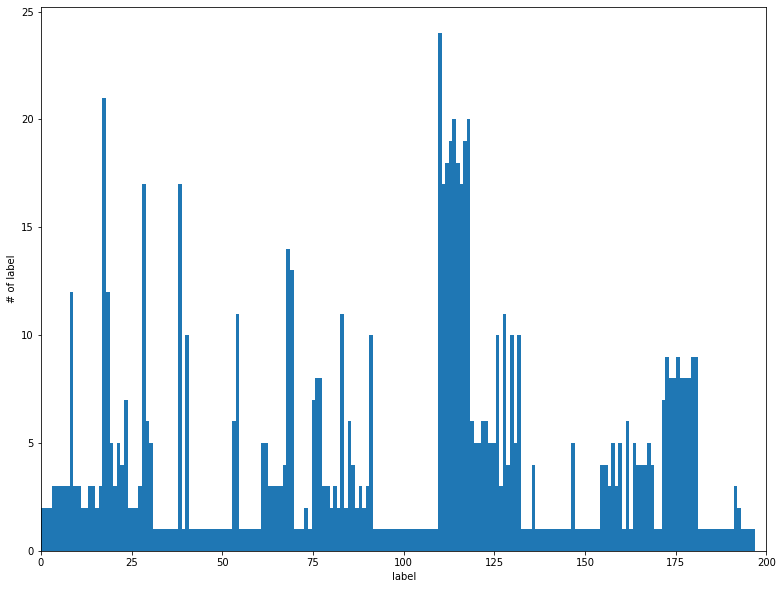

In [3]:
train_label = pd.read_csv("train_label.csv")
plt.hist(train_label['label'], bins=len(train_label['label'].unique()))
plt.xlim(0,200)
plt.ylim(bottom=0)
plt.xlabel('label')
plt.ylabel('# of label')
plt.show()

In [4]:
# 전체적으로 Imbalance Data, 1개뿐인 라벨이 많음

In [5]:
# Bad, CLOSE, Equip Fail, No Data, Normal, OFF, ON, OPEN, System.Char[] 등 문자열 데이터를 포함

In [6]:
realData1 = "Train/30.csv"
realData2 = "Test/1154.csv"
realData3 = "Test/1168.csv"
realData4 = "additinal_data/additinal_data1"
realData5 = "additinal_data/additinal_data2"

In [7]:
train_folder = 'train/'
test_folder = 'test/'
train_label_path = 'train_label.csv'

In [8]:
train_list = os.listdir(train_folder)
test_list = os.listdir(test_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

# DataPreprocessn  

In [9]:
# 모든 csv 파일의 상태_B로 변화는 시점이 10초로 가정
def data_loader_v2_all(func, files, folder='', train_label=None, event_time=10, nrows=60):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df

In [10]:
#train = data_loader_v2_all(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=10, nrows=60)
#train.to_csv("base_train.csv")
train = pd.read_csv("base_train.csv", index_col='Unnamed: 0')

In [ ]:
# 모든 test 셋 데이터에 대해서 10초부터 상태_B가 시작된다고 가정 
test = data_loader_v2_all(data_loader_v2, test_list, folder=test_folder, train_label=None, event_time=10, nrows=60)
test.to_csv("base_test.csv")
test = pd.read_csv("base_test.csv", index_col='Unnamed: 0')

In [10]:
train_1 = train.copy()
train_y = train_1['label']
train_1 = train_1.drop(['label'], axis=1)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(train_1, train_y, test_size=0.2, random_state=seed)
print(X_train,X_test,Y_train,Y_test)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

       Unnamed: 0      V0000     V0001     V0002     V0003     V0004  \
25920         666  30.460902  8.696729  8.678150  8.707048  8.743941   
31215         675  30.467751  8.634908  8.721089  8.677828  8.720551   
6486          547  30.473759  8.729892  8.689503  8.666899  8.672289   
25275         248  30.484401  8.759098  8.716958  8.730716  8.687358   
32890         389  30.469542  8.785799  8.717737  8.735726  8.717749   
...           ...        ...       ...       ...       ...       ...   
10879         811  23.635265  4.311902  4.222889  3.817453  3.780163   
26695         317  30.477458  8.750068  8.722127  8.723330  8.707557   
36785         589  30.470703  8.831234  8.686700  8.706548  8.714215   
40535         819  30.446290  8.736160  8.680907  8.678161  8.692547   
15931         525  30.476703  8.689716  8.664188  8.677084  8.653015   

            V0005       V0006         V0007  V0008  ...  V5111  V5112  V5113  \
25920  187.271493  220.187777 -2.609061e-19    0.0  ...

In [116]:
stdScaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_train = stdScaler.fit_transform(X_train)
X_Test = stdScaler.fit_transform(X_test)

In [122]:
type(X_train)

numpy.ndarray

# RandomForestClaasifier

In [57]:
model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
model.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [61]:
expected_y  = Y_test
predicted_y = model.predict(X_test).round()
print(); print('RandomForestClassifier: ')
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s



RandomForestClassifier: 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       1.00      0.47      0.64        17
           2       0.95      0.82      0.88        22
           3       0.91      0.80      0.85        25
           4       0.96      0.71      0.82        38
           5       1.00      0.85      0.92        41
           6       1.00      0.92      0.96        37
           7       1.00      0.93      0.96        28
           8       0.68      0.92      0.78       125
           9       0.23      0.11      0.15        28
          10       0.33      0.75      0.46        32
          11       0.00      0.00      0.00        22
          12       0.88      0.28      0.42        25
          13       1.00      0.06      0.11        35
          14       0.25      0.27      0.26        30
          15       0.60      0.56      0.58        16
          16       0.40      0.29      0.33        35


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LightGBM

In [121]:
train_1.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_1.columns]

X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

train_ds = lgb.Dataset(X_train, label = Y_train)
test_ds = lgb.Dataset(X_test, label = Y_test)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [11]:
model = lgb.LGBMClassifier()
#model.fit(X_train,Y_train)
lgb_params = {
        'objective':'multiclass',
        'metric':'multi_logloss',
        'num_class':198,
        'learning_rate':0.02,
        'seed': 5,
        'n_jobs': -1
    
    }

In [12]:
model = lgb.train(lgb_params, train_ds, 100, test_ds, verbose_eval=True, early_stopping_rounds=20)

[1]	valid_0's multi_logloss: 3.28624
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.02749
[3]	valid_0's multi_logloss: 2.84508
[4]	valid_0's multi_logloss: 2.69981
[5]	valid_0's multi_logloss: 2.57696
[6]	valid_0's multi_logloss: 2.47148
[7]	valid_0's multi_logloss: 2.37878
[8]	valid_0's multi_logloss: 2.29634
[9]	valid_0's multi_logloss: 2.22167
[10]	valid_0's multi_logloss: 2.15358
[11]	valid_0's multi_logloss: 2.09138
[12]	valid_0's multi_logloss: 2.03358
[13]	valid_0's multi_logloss: 1.97991
[14]	valid_0's multi_logloss: 1.92964
[15]	valid_0's multi_logloss: 1.88244
[16]	valid_0's multi_logloss: 1.83787
[17]	valid_0's multi_logloss: 1.79593
[18]	valid_0's multi_logloss: 1.75591
[19]	valid_0's multi_logloss: 1.718
[20]	valid_0's multi_logloss: 1.68209
[21]	valid_0's multi_logloss: 1.64778
[22]	valid_0's multi_logloss: 1.61461
[23]	valid_0's multi_logloss: 1.58296
[24]	valid_0's multi_logloss: 1.55287
[25]	valid_0's multi_logloss: 1.5239
[

In [13]:
import joblib
#joblib.dump(model, 'lgbmodel.pkl')

In [17]:
model = joblib.load('lgbmodel.pkl')

In [25]:
#model2.fit(lgb_params, train_ds, 100, test_ds, early_stopping_rounds=20)
model3 = lgb.LGBMClassifier(learning_rate=0.02, boosting_type = 'gbdt', metric = 'multi_logloss', seed = 777, n_jobs = -1)
evals = [(X_test, Y_test)]
model3.fit(X_train, Y_train, eval_set=evals, eval_metric='logloss', early_stopping_rounds=20, verbose=True)

[1]	valid_0's multi_logloss: 3.42254
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.16563
[3]	valid_0's multi_logloss: 2.97826
[4]	valid_0's multi_logloss: 2.82815
[5]	valid_0's multi_logloss: 2.70191
[6]	valid_0's multi_logloss: 2.59368
[7]	valid_0's multi_logloss: 2.49889
[8]	valid_0's multi_logloss: 2.41394
[9]	valid_0's multi_logloss: 2.33726
[10]	valid_0's multi_logloss: 2.26742
[11]	valid_0's multi_logloss: 2.20302
[12]	valid_0's multi_logloss: 2.14349
[13]	valid_0's multi_logloss: 2.08791
[14]	valid_0's multi_logloss: 2.03615
[15]	valid_0's multi_logloss: 1.98765
[16]	valid_0's multi_logloss: 1.94191
[17]	valid_0's multi_logloss: 1.89833
[18]	valid_0's multi_logloss: 1.85715
[19]	valid_0's multi_logloss: 1.81802
[20]	valid_0's multi_logloss: 1.78094
[21]	valid_0's multi_logloss: 1.74565
[22]	valid_0's multi_logloss: 1.71172
[23]	valid_0's multi_logloss: 1.67943
[24]	valid_0's multi_logloss: 1.64842
[25]	valid_0's multi_logloss: 1.6186

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=-1,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, seed=777, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
import joblib

In [44]:
joblib.dump(model3, 'lgbmodel_3.pkl')

['lgbmodel_3.pkl']

In [46]:
#expected_y  = Y_test
#predicted_y = model3.predict(X_test).round()
#print(); print('LightGBM: ')
#print(predicted_y)
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       1.00      0.68      0.81        25
           2       1.00      0.76      0.86        21
           3       0.97      0.85      0.91        41
           4       1.00      0.88      0.94        34
           5       0.91      0.84      0.87        25
           6       1.00      0.83      0.91        36
           7       1.00      0.91      0.95        32
           8       1.00      1.00      1.00       110
           9       0.56      0.14      0.23        35
          10       0.32      0.39      0.35        28
          11       0.00      0.00      0.00        16
          12       0.88      0.33      0.48        21
          13       0.75      0.22      0.34        27
          14       0.54      0.26      0.35        27
          15       0.65      0.83      0.73        18
          16       0.36      0.36      0.36        22
          17       0.80   

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
pred = model3.predict_proba(test)
submission = pd.DataFrame(data=pred)
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean().round(6)
submission.to_csv('submission_3.csv', index=True) #제출 파일 만들기

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
id,,,,,,,,,,,,,,,,,,,,,
828,0.000094,0.000092,0.000096,0.000133,0.000141,0.000152,0.000139,0.000144,0.000595,0.000140,...,0.000049,0.000045,0.000045,0.000049,0.000134,0.000096,0.000052,0.000049,0.000046,0.000074
829,0.000741,0.000730,0.000760,0.001049,0.001116,0.001202,0.001111,0.001142,0.004683,0.001106,...,0.000385,0.000356,0.000356,0.000385,0.001058,0.000794,0.000414,0.000382,0.000360,0.000430
830,0.000528,0.000510,0.000537,0.000741,0.000789,0.000850,0.000783,0.000813,0.003310,0.000782,...,0.000272,0.000252,0.000252,0.000272,0.000748,0.000559,0.000242,0.000273,0.000260,0.000315
831,0.000548,0.000534,0.000563,0.000776,0.001340,0.000889,0.000811,0.000840,0.003465,0.000818,...,0.000285,0.000264,0.000264,0.000285,0.000783,0.000620,0.000257,0.000301,0.000264,0.000324
832,0.000714,0.000526,0.000549,0.001000,0.000861,0.000988,0.000850,0.000788,0.003137,0.001647,...,0.000258,0.000239,0.000239,0.000258,0.000709,0.000533,0.000232,0.000265,0.000263,0.000302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,0.000996,0.000999,0.001135,0.001431,0.001754,0.002355,0.001927,0.001604,0.006157,0.002425,...,0.000506,0.000468,0.000468,0.000506,0.001391,0.001055,0.000489,0.000509,0.000478,0.000929
1544,0.000060,0.000059,0.000061,0.000084,0.000090,0.000097,0.000090,0.000092,0.000377,0.000089,...,0.973686,0.000029,0.000029,0.000031,0.000085,0.000391,0.000030,0.000034,0.000031,0.000037
1545,0.000553,0.000541,0.000567,0.000782,0.000832,0.000897,0.000824,0.000851,0.003493,0.000825,...,0.000287,0.000266,0.000266,0.000287,0.000789,0.000599,0.000266,0.000291,0.000276,0.000341
